# Fabian's Object Classifier

**Initialization**

In [1]:
import os
import random
import cv2
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler
from torchvision import transforms, models
from shutil import copy, rmtree

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(SEED)

In [2]:
batch_size = 7
num_labels = 107

original_train_images_path = '/kaggle/input/classification-with-limited-data/food/train/images'
original_train_labels_path = '/kaggle/input/classification-with-limited-data/food/train/train.csv'
test_images_path = '/kaggle/input/classification-with-limited-data/food/test/images'
train_images_path = '/kaggle/working/train/images'
valid_images_path = '/kaggle/working/val/images'
model_path = '/models'

# Loads labels from csv.
labels_df = pd.read_csv(original_train_labels_path)

paths = [train_images_path, valid_images_path, model_path]
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

In [3]:
# Creates training and validation data and saves it to the corresponding path.
file_list = os.listdir(original_train_images_path)

valid_list = random.sample(file_list, int(len(file_list) * 0.1))   # 1070 * 0,1 = 107 validation images
for file in file_list:
    path = ''
    if file in valid_list:
        path = valid_images_path
    else:
        path = train_images_path
        
    copy(os.path.join(original_train_images_path, file), os.path.join(path, file))
    
train_list = os.listdir(train_images_path)
print("Number of training images: " + str(len(train_list)))         # 963 training images
print("Number of validation images: " + str(len(valid_list)))       # 107 validation images

Number of training images: 963
Number of validation images: 107


**Investigation of the different labels**

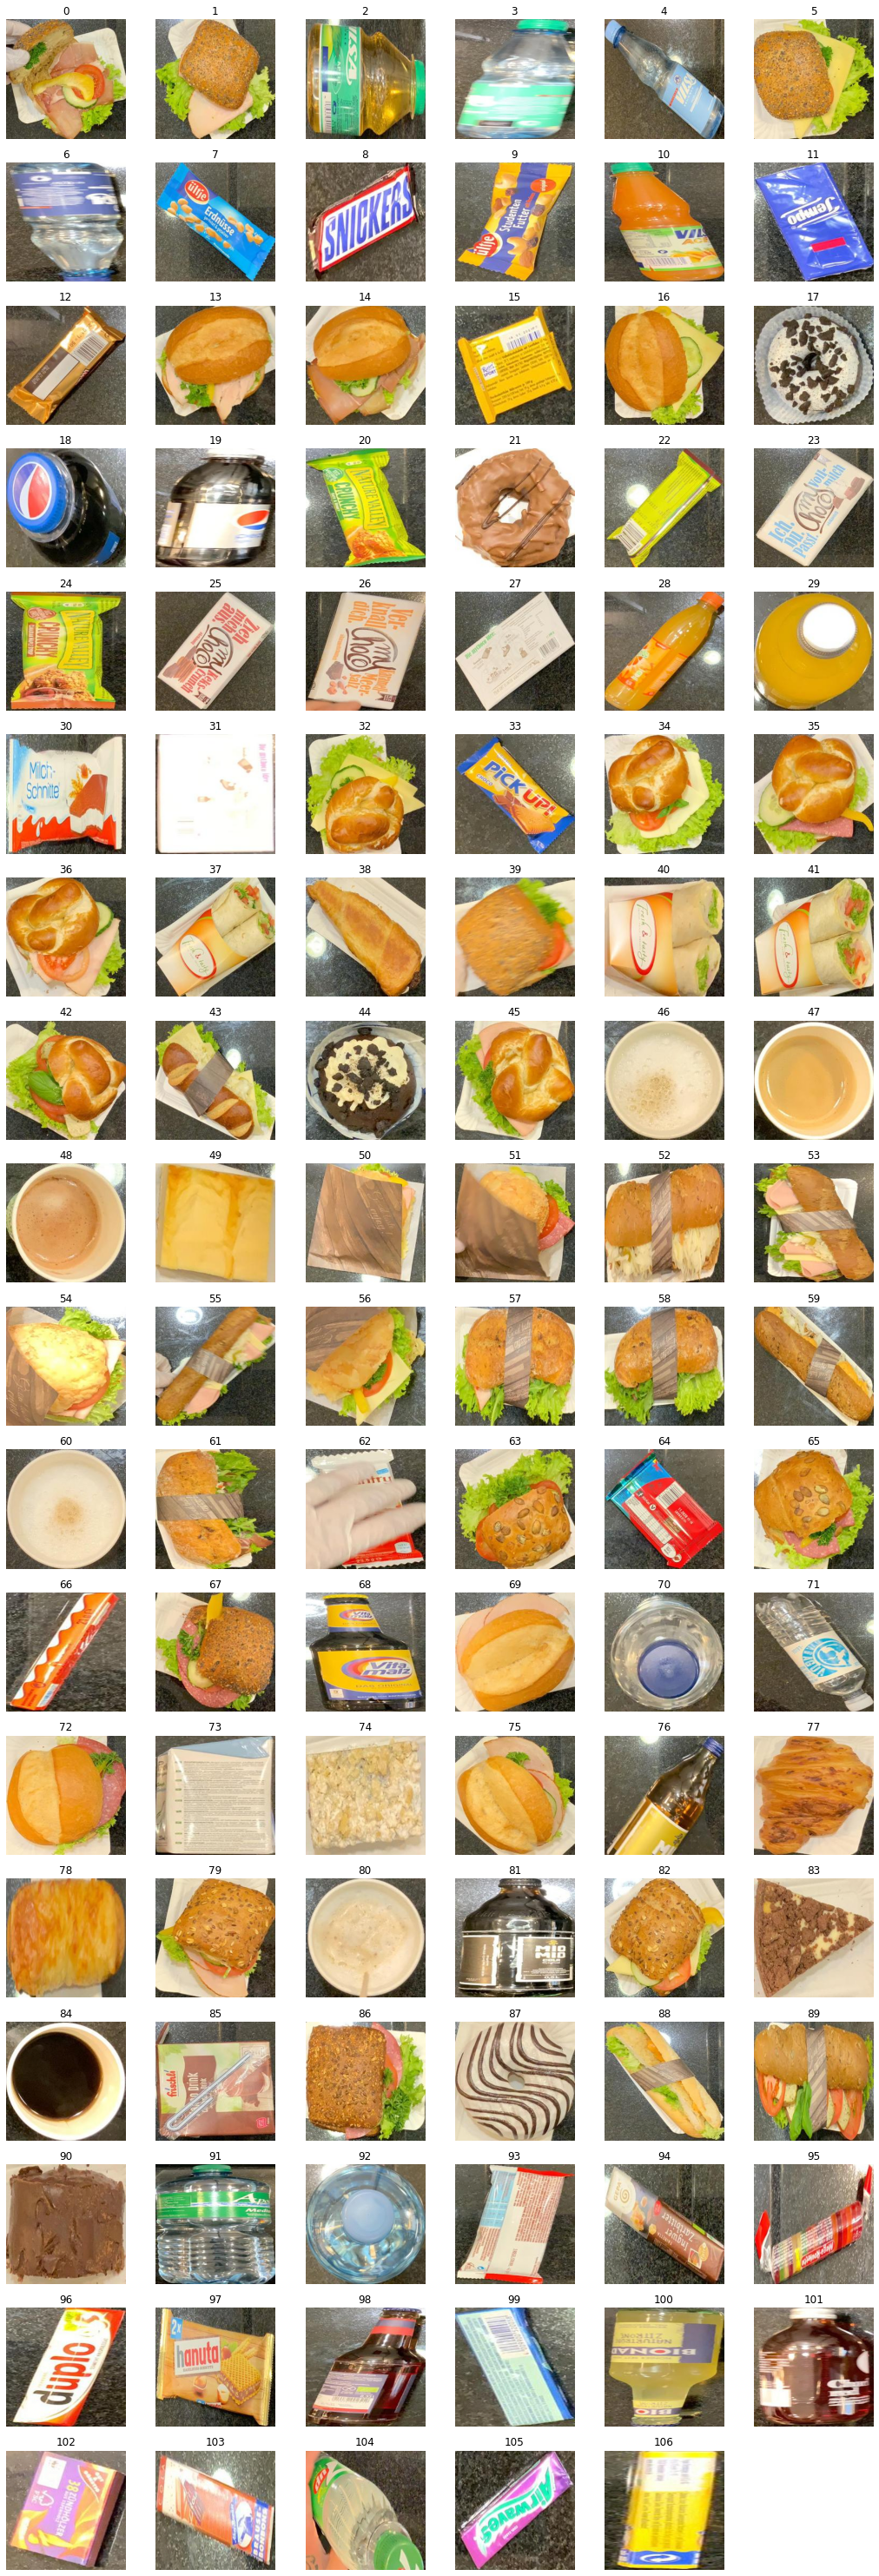

In [4]:
labels = sorted(labels_df['Expected'].unique())
cols = 6
rows = 18

plt.figure(figsize=(3 * cols, 3 * rows))
for i, label in enumerate(labels):
    file = labels_df[labels_df['Expected'] == label]['Id'].values[0]
    img = cv2.imread(os.path.join(original_train_images_path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
plt.show()

**Datasets**

In [5]:
class FoodDataset(Dataset):
    def __init__(self, path, labels_df, transform=None):
        # Loads file names and the according labels.
        self.path = path
        self.files = list(sorted(os.listdir(os.path.join(path))))
        self.labels = [labels_df[labels_df['Id'] == file]['Expected'].values[0] for file in self.files]
        self.labels = torch.LongTensor(np.array(self.labels))
        self.transform = transform

    def __getitem__(self, index):
        # Loads image and corresponding label.
        img = cv2.imread(os.path.join(self.path, self.files[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        label = self.labels[index]

        # Applies transform.
        if self.transform:
            # Converts numpy array to PIL image, including conversion from 0-255 to 0-1
            img = Image.fromarray(img.astype(np.uint8))
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.files)

In [6]:
# Defines image transformations.
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(0.25),
                                      transforms.RandomRotation(180),
                                      transforms.RandomHorizontalFlip(0.25),
                                      transforms.ColorJitter(brightness=0.3, contrast=0.25, saturation=0.25),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     
                                     ])

transform_valid = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

# Creates datsets.
train_dataset = FoodDataset(train_images_path, labels_df, transform=transform_train)
valid_dataset = FoodDataset(valid_images_path, labels_df, transform=transform_valid)

# Creates dataloaders (including batchsize and random sampling)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

25


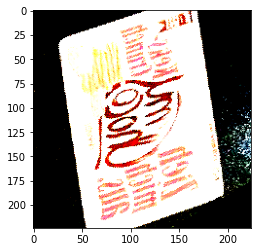

In [7]:
idx = random.randint(0, len(train_dataset))
images, labels = train_dataset[idx]

plt.imshow(images.numpy().transpose(2,1,0))
print(labels.numpy())

**Model**

In [8]:
import torch.nn as nn

# Uses a pretrained model as basis.
net = models.resnext101_32x8d(pretrained=True)
#net = models.densenet169(pretrained=True)

# Adds an additional dropout layer.
net.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, num_labels))

# Uses GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [9]:
# Defines loss, optimizer and learning rate scheduler.
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True, min_lr=1e-8)

**Training**

In [10]:
# Initializes empty lists to save the losses and accuracies.
loss_train = []
loss_valid = []
acc_train = []
acc_valid = []

n_epochs = 30
valid_loss = 0.0

train_loader_sel = train_loader
train_dataset_sel = train_dataset

# Initializes best model loss.
if valid_loss:
    best_model_loss = valid_loss
    last_best_model_loss = valid_loss + 1
else:
    best_model_loss = float("inf")
    last_best_model_loss = float("inf")

# Initializes some more variables for visualization of the training progress.
t = time.time()
len_train = len(train_loader_sel)

# Sets update interval of the output. Increase the number in the end to decrease the update intervall
update_interval = round(len_train / 10)

# Training
for epoch in range(n_epochs):

    net.train()
    train_loss = 0.0
    correct_train_pred = 0
    
    # Repeats over training batches.
    for i, data in enumerate(train_loader_sel, 0):
        # Gets the inputs and puts them into the GPU if available.
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zeros the parameter gradients.
        optimizer.zero_grad()

        # Forward- and backpropagation
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Checks if prediction is correct.
        for lbl in range(len(labels)):
            prob = outputs.detach().cpu().numpy()[lbl]
            prediction = np.argmax(prob)
            if prediction == labels[lbl].item():
                correct_train_pred += 1
        
        # Prints training progress data.
        if i % update_interval == update_interval-1:
            print('[%d, %5d] Loss: %.3f Time: %.1f min' %
                  (epoch + 1, (i + 1) * batch_size, train_loss / (i + 1), (time.time() - t) / 60), end='\r')   
    
    # Evaluation
    net.eval()
    valid_loss = 0.0
    correct_valid_pred = 0
    
    # Repeats over validation batches.
    for j, data in enumerate(valid_loader, 0):
        with torch.no_grad():
            # Gets the inputs and puts them into the GPU if available.
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forwardpropagation
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            
            # Checks if prediction is correct.
            for lbl in range(len(labels)):
                prob = outputs.detach().cpu().numpy()[lbl]
                prediction = np.argmax(prob)
                if prediction == labels[lbl].item():
                    correct_valid_pred += 1
                    
    # Does a scheduler step. If loss doesn't decrease for some epochs, learning rate is reduced by half.
    scheduler.step(valid_loss)
    
    # Appends losses and accuracies to the corresponding lists.
    loss_train.append(train_loss / len(train_dataset_sel))
    loss_valid.append(valid_loss / len(valid_dataset))
    acc_train.append(correct_train_pred / float(len(train_dataset_sel)))
    acc_valid.append(correct_valid_pred / float(len(valid_dataset)))
    
    # Displays current training progress.
    time_remaining = (time.time() - t) / (epoch + 1) * (n_epochs - epoch) / 60
    print('[%d / %d, %5d]  Time: %.1f min Time remaining: %.1f min \n Train Loss: %.3f Train TP: %d / %d \n Valid Loss: %.3f Valid TP: %d / %d' % 
          (epoch + 1, n_epochs, len(train_dataset_sel), (time.time() - t) / 60, time_remaining, train_loss / len(train_dataset_sel) * batch_size, correct_train_pred, len(train_dataset_sel), valid_loss / len(valid_dataset) * batch_size, correct_valid_pred, len(valid_dataset)))
    
    # Saves the model if it is better than the best so far.
    if best_model_loss > valid_loss:
        last_best_model_loss = best_model_loss
        best_model_loss = valid_loss
        best_model_path = os.path.join(model_path, 'best_model.bin')
        if os.path.isfile(best_model_path): 
            os.rename(best_model_path, os.path.join(model_path, 'last_best_model.bin'))
        torch.save(net.state_dict(), os.path.join(model_path, 'best_model.bin'))
        print('Model with loss of %0.3f saved.' % (best_model_loss / len(valid_dataset)))

print('Finished Training')

[1 / 30,   963]  Time: 0.9 min Time remaining: 25.7 min 
 Train Loss: 4.175 Train TP: 100 / 963 
 Valid Loss: 2.771 Valid TP: 34 / 107
Model with loss of 0.396 saved.
[2 / 30,   963]  Time: 1.6 min Time remaining: 23.7 min 
 Train Loss: 2.370 Train TP: 418 / 963 
 Valid Loss: 1.215 Valid TP: 66 / 107
Model with loss of 0.174 saved.
[3 / 30,   963]  Time: 2.4 min Time remaining: 22.5 min 
 Train Loss: 1.309 Train TP: 651 / 963 
 Valid Loss: 0.797 Valid TP: 79 / 107
Model with loss of 0.114 saved.
[4 / 30,   963]  Time: 3.2 min Time remaining: 21.5 min 
 Train Loss: 0.813 Train TP: 783 / 963 
 Valid Loss: 0.363 Valid TP: 93 / 107
Model with loss of 0.052 saved.
[5 / 30,   963]  Time: 4.0 min Time remaining: 20.6 min 
 Train Loss: 0.486 Train TP: 868 / 963 
 Valid Loss: 0.173 Valid TP: 101 / 107
Model with loss of 0.025 saved.
[6 / 30,   963]  Time: 4.7 min Time remaining: 19.7 min 
 Train Loss: 0.327 Train TP: 912 / 963 
 Valid Loss: 0.164 Valid TP: 104 / 107
Model with loss of 0.023 sav

**Visualization**

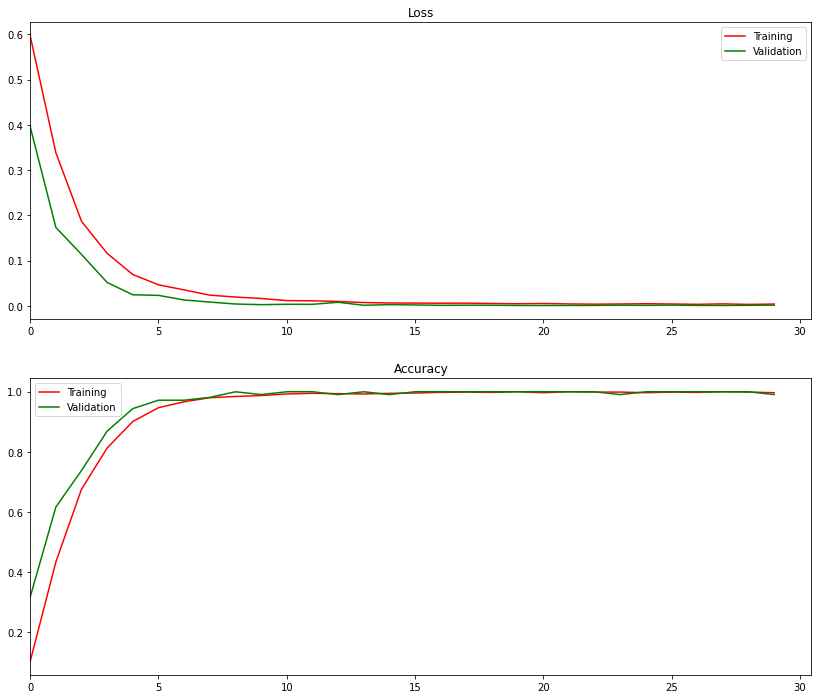

In [11]:
range_loss = np.arange(0, len(loss_train))

# Displays losses and accuracies of the training progress.
plt.figure(figsize = (14, 12))
plt.subplot(211)
plt.title("Loss")
plt.plot(range_loss, loss_train, 'r', label = 'Training')
plt.plot(range_loss, loss_valid, 'g', label = 'Validation')
plt.legend()
plt.xlim(left = 0)
plt.subplot(212)
plt.title("Accuracy")
plt.plot(range_loss, acc_train, 'r', label = 'Training')
plt.plot(range_loss, acc_valid, 'g', label = 'Validation')
plt.legend()
plt.xlim(left = 0)
plt.show()

**Generation of csv file for submission**

In [12]:
df = pd.DataFrame(columns=["Id", "Expected"])

for file in os.listdir(test_images_path):
    # Loads image.
    img = cv2.imread(os.path.join(test_images_path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    # Applies necessary preprocessing.
    img = transform_valid(Image.fromarray(img.astype(np.uint8)))
    img = torch.unsqueeze(img, 0)
    img = img.to(device)
    
    # Gets prediction from the model and saves it.
    prob = net(img).detach().cpu().numpy()[0]
    prediction = np.argmax(prob)
    df.loc[len(df)] = [file, prediction]
    
df
df.to_csv('submission.csv', index = False)

# Necessary step to obtain an output file after commit and run all.
paths = [train_images_path, valid_images_path]
for path in paths:
    if os.path.isdir(path):
        rmtree(path)

patch = os.path.join(model_path, 'last_best_model.bin')
if os.path.isfile(path):
    os.remove(os.path.join(model_path, 'last_best_model.bin'))